# Conditional Normalizing Flow Model

Here, we train a conditional normalizing flow model $q(x|c)$. Our target $p(x|c)$ is a simple 2D Gaussian $\mathcal{N}(x|\mu, \sigma)$, where we condition on the mean $\mu$ and standard deviation $\sigma$, i.e. $c = (\mu, \sigma)$. We apply conditional autoregressive and coupling neural spline flows as well as a conditional masked autoregressive flow to the problem.

## Setup

In [44]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plt
import math
from tqdm import tqdm
from util import PVect, theta_func

In [2]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Data - closest x pos, 5GeV muons, one z position - emission time
uproot_path = f"/cwork/rck32/eic/work_eic/root_files/July_1/slurm/mu_vary_z_theta/5GeV_500events_TEST.edm4hep.root:events" #(gun x 1769)
events = up.open(uproot_path)

In [46]:
hit_time_branch = events["HcalBarrelHits.time"].array(library='np')
hit_x_pos_branch = events["HcalBarrelHits.position.x"].array(library='np')
hit_z_pos_branch = events["HcalBarrelHits.position.z"].array(library='np')
Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')


x_pos_branch = events["MCParticles/MCParticles.vertex.x"].array(library='np')
z_pos_branch = events["MCParticles/MCParticles.vertex.z"].array(library='np')
PDG_branch = events["MCParticles.PDG"].array(library='np')
mass_branch = events["MCParticles.mass"].array(library='np')

momentum_x_branch = events["MCParticles.momentum.x"].array(library='np')
momentum_y_branch = events["MCParticles.momentum.y"].array(library='np')
momentum_z_branch = events["MCParticles.momentum.z"].array(library='np')

emission_time_branch = events["MCParticles/MCParticles.time"].array(library='np')
daughter_end_branch = events["MCParticles/MCParticles.daughters_end"].array(library='np')
daughter_begin_branch = events["MCParticles/MCParticles.daughters_begin"].array(library='np')

#### Data preparation
Need 5 features:
1. Four conditionals:
    1. Hit z position (calculate from shoot position and angle)
    2. hit time (calculate from momentum and distance)
    3. hit theta (calculate from momentum vector)
    4. hit momenta (calculate from momentum vector)
2. Feature
    1. photon hit time on sensor

##### Status
1. Hit z, hit theta, hit momenta and photon hit time are all good
1. Just need to calculate hit time from momentum (velocity) and distance traveled (use pythogorean theorem with x and z)

In [45]:
def z_func(z_vertex, theta):
    return z_vertex + 10 * math.tan(math.pi / 2 - theta)

In [47]:
inputs = torch.ones(1,5)
init = False
break_limit = -1
for event_idx in range(len(PDG_branch)):
    if(break_limit > 0 and event_idx > break_limit):
        break
    #Primary stuff
    primary = PVect()
    primary.setVector(momentum_x_branch[event_idx][0],momentum_y_branch[event_idx][0],momentum_z_branch[event_idx][0],mass_branch[event_idx][0])
    theta = primary.theta
    P = primary.P
    vertex_z = z_pos_branch[event_idx][0]
    for hit_idx in range(len(hit_z_pos_branch[event_idx])):
        if(PDG_branch[event_idx][Hits_MC_idx_branch[event_idx][hit_idx]] != -22):
            continue
        hit_z = z_func(vertex_z, theta)
        hit_time = hit_time_branch[event_idx][hit_idx]
        hit_tensor = torch.ones(1,5) * 10
        hit_tensor[0,0] = float(hit_z)
        hit_tensor[0,1] = float(hit_time)
        hit_tensor[0,2] = float(theta)
        hit_tensor[0,3] = float(P)
        if(not init):
            inputs[0] = hit_tensor[0]
            init = True
        else:
            inputs = torch.cat((inputs,hit_tensor),0)
            
        

In [48]:
inputs

tensor([[ 15.7081,   5.4747, 149.4030,   5.0000,  10.0000],
        [ 15.7081,   6.7606, 149.4030,   5.0000,  10.0000],
        [ 15.7081,   4.9195, 149.4030,   5.0000,  10.0000],
        ...,
        [  5.7601,   7.0930,  21.2856,   5.0000,  10.0000],
        [  5.7601,   5.8604,  21.2856,   5.0000,  10.0000],
        [  5.7601,   4.3056,  21.2856,   5.0000,  10.0000]])

## Masked Autoregressive Flow

### Model specification

In [17]:
# Define flows
K = 4

latent_size = 1
hidden_units = 128
num_blocks = 2
context_size = 5

flows = []
for i in range(K):
    flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden_units, 
                                                  context_features=context_size, 
                                                  num_blocks=num_blocks)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)

### Training

100%|████████████████████████████████████████████████████████████| 5000/5000 [02:00<00:00, 41.53it/s]


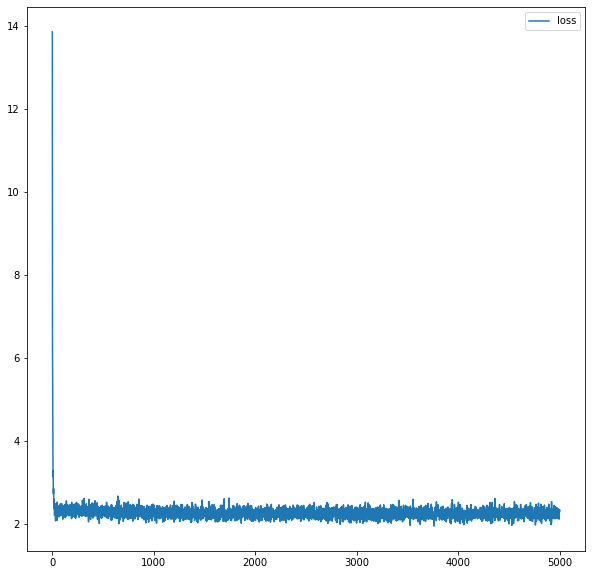

In [14]:
# Train model
max_iter = 5000
batch_size= 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    context = torch.cat([torch.randn((batch_size, 2), device=device), 
                         0.5 + 0.5 * torch.rand((batch_size, 2), device=device)], 
                        dim=-1)
    x = target.sample(batch_size, context)
    
    # Compute loss
    loss = model.forward_kld(x, context)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

### Evaluation

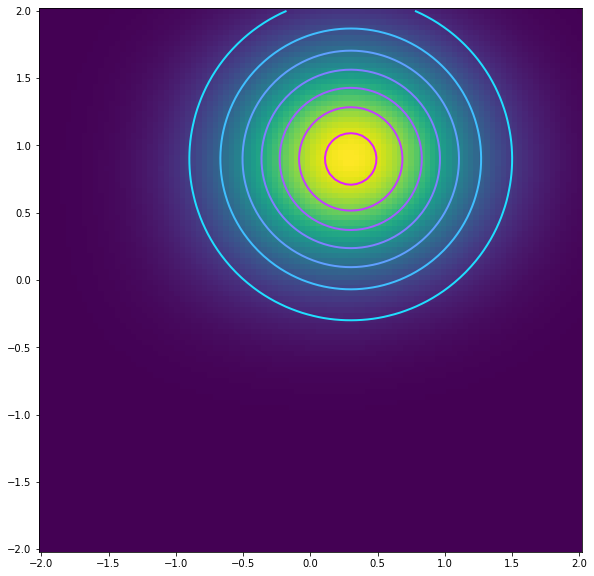

In [15]:
# Plot trained flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()